# JRA55 NAO signal

ACCESS-CM2 shows a clear North Atlantic Oscillation (NAO) signal. For more details, see [this](https://github.com/dhruvbhagtani/North-Atlantic-Oscillation-tests/blob/main/NAO_indices_with_NAmask.ipynb) jupyter notebook. 

Next, we need to check if we have this signal in JRA55-do forcing. However, the traditional approach to calculate the NAOi is by taking the EOF of geopotential height at 500 hPa. With JRA forcing, 

In [205]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [1]:
#import dask
#from dask.distributed import Client
#client = Client()
#client

In [2]:
## 1. Run to analyse

dir = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/'
run = 'r1i1p1f1'
scenario = 'historical'

## 2. Start and end times
start_time, end_time = '1958-12-01', '2014-11-30'

## 3. North Atlantic ocean coordinates
x_min, x_max = -90, 10
y_min, y_max = 10, 75

## 4. Constants
m3_to_Sv = 1e6
ρ0 = 1036
neofs = 3
neigs = 3
npcs = 3
r0 = 6.371 * 10**6

## 5. Plotting land boundaries
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

In [3]:
model_out = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')

def regridder(da_in, label):
    if(label == 'ocean'):
        return regridder_ocean_to_ocean(da_in)
    elif(label == 'atmos'):
        return regridder_atmos_to_ocean(da_in)
    else:
        print('Error: Select between ocean and atmos grids.')
        
def regridder_atmos_to_ocean(da_in):
    grid_in = {'lon': da_in.lon.values, 'lat': da_in.lat.values}
    grid_out = {'lon': model_out.xt_ocean.values, 'lat': model_out.yt_ocean.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)
    
    regridded_da = regridded_da.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
    regridded_da = regridded_da.assign_coords({"geolon_t": model_out.geolon_t, "geolat_t": model_out.geolat_t})

    return regridded_da

def regridder_ocean_to_ocean(da_in):
    grid_in = {'lon': da_in.longitude.values, 'lat': da_in.latitude.values}
    grid_out = {'lon': model_out.geolon_t.values, 'lat': model_out.geolat_t.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)

    regridded_da = regridded_da.rename({"y": "yt_ocean", "x": "xt_ocean"})
    regridded_da = regridded_da.assign_coords({"xt_ocean": model_out.xt_ocean, "yt_ocean": model_out.yt_ocean})
    regridded_da = regridded_da.rename({"lon": "geolon_t", "lat": "geolat_t"})

    return regridded_da

In [4]:
SLP_total = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/psl_JRA55-do-1-4-0.nc')
SLP_total = SLP_total.psl.sel(time = slice(start_time, end_time))
SLP_total['time'] = SLP_total['time'].values.astype('datetime64[M]') + np.timedelta64(13, 'D')
SLP_NA = SLP_total.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

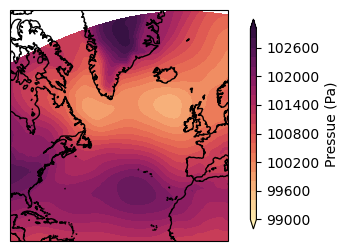

In [5]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), subplot_kw = {'projection': projection})

p1 = axes.contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, SLP_NA[0], levels = np.linspace(0.99e5, 1.03e5, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressue (Pa)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')

In [6]:
# Take the 500 hPa geopotential height and selecting Dec, Jan, Feb data only
hgt500 = xr.open_dataset(dir + '/' + scenario + '/' + run + '/' + '/Amon/zg/gn/latest/zg_Amon_ACCESS-CM2_' + scenario + '_' + run + '_gn_195001-201412.nc').zg.sel(plev = 50000, method = 'nearest')
hgt500 = hgt500.sel(time = slice(start_time, end_time))

# Selecting Dec, Jan, Feb months
hgt500 = hgt500.where(hgt500.time.dt.month.isin([12, 1, 2]), drop = True)

# Regridding to a proper grid
hgt500 = regridder(hgt500, 'atmos')
hgt500

# Selecting North Atlantic region
hgt500_NA = hgt500.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

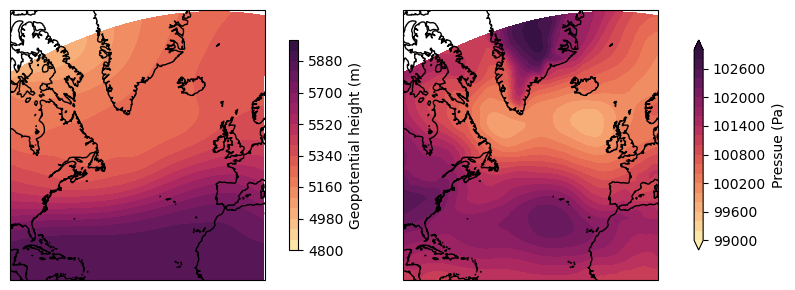

In [7]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(hgt500_NA.geolon_t, hgt500_NA.geolat_t, hgt500_NA[0], levels = np.linspace(4800, 6000, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree())

p2 = axes[1].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, SLP_NA[0], levels = np.linspace(0.99e5, 1.03e5, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Geopotential height (m)', fontsize = 10)

cax = plt.axes([0.9, 0.15, 0.01, 0.7])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressue (Pa)', fontsize = 10)

for i in range(2):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')

plt.tight_layout()
plt.show()

In [8]:
# Compute anomalies
SLP_NA_mean = SLP_NA.mean('time')
SLP_NA_amly = SLP_NA - SLP_NA_mean

In [9]:
# Solve for EOF.
coslat = np.cos(np.deg2rad(SLP_NA.yt_ocean.values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver_DJF_SLP = Eof(SLP_NA_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_DJF_SLP = solver_DJF_SLP.eofsAsCovariance(neofs = neofs)

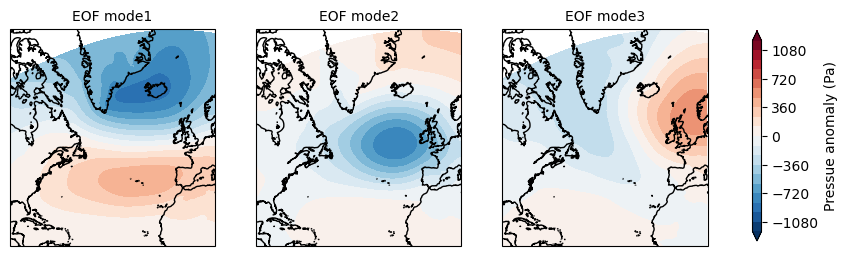

In [10]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_DJF_SLP[0], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_DJF_SLP[1], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_DJF_SLP[2], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressue anomaly (Pa)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [11]:
# Fraction
print('Percentage of EOF explained by first ' + str(neigs) + ' modes:' + str(100 * np.round(solver_DJF_SLP.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 modes:[43.51     22.27     12.620001]


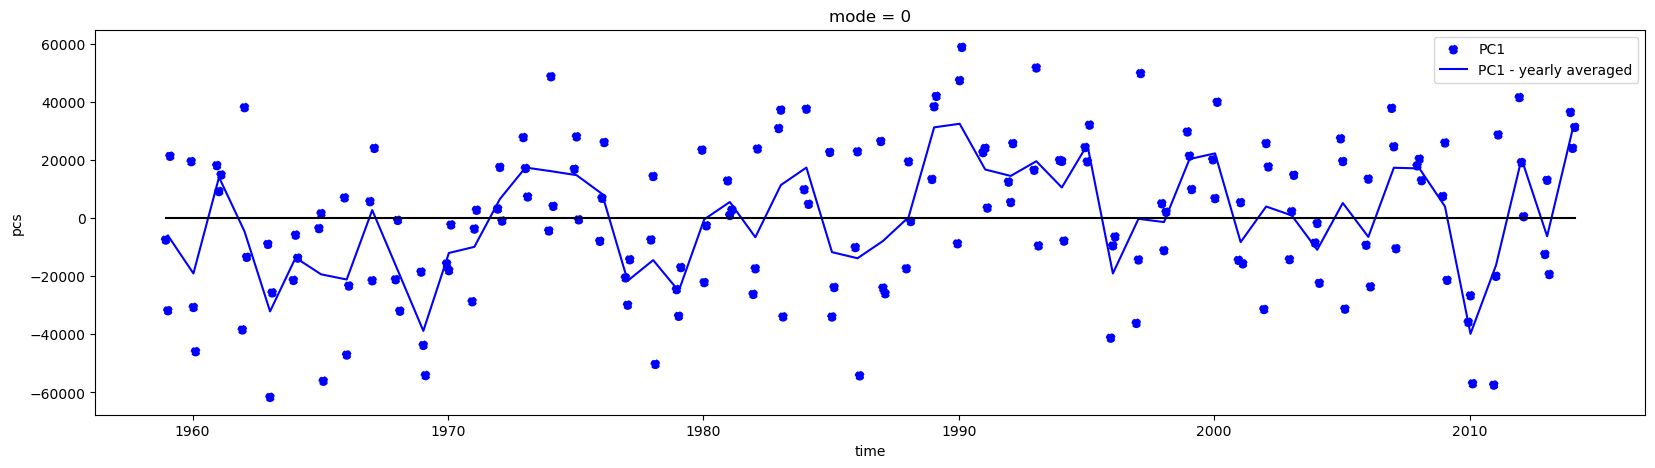

In [12]:
plt.figure(figsize = (20, 5))
#npcs = number of PCs, 
#pscaling = 0 -> unscaled variance scaling of PCs
#         = 1 -> scaled to unit variance
#         = 2 -> PC multiplied by the square root of their eigenvalue

pcs_SLP_DJF = solver_DJF_SLP.pcs(npcs = npcs, pcscaling = 0)
pcs_SLP_DJF.sel(mode = 0).plot.scatter(color = 'blue', label = 'PC1', ls = '--')
pcs_SLP_DJF.sel(mode = 0).coarsen(time = 3).mean().plot(color = 'blue', label = 'PC1 - yearly averaged')
plt.plot(pcs_SLP_DJF.sel(mode = 1).time, np.zeros(168), color = 'black')
plt.legend()

## Testing 1 degree simulation 

We test the `1deg_jra55_iaf_omip2spunup_cycle1` for NAO signals.

In [13]:
session = cc.database.create_session()
experiment = '1deg_jra55_iaf_omip2spunup_cycle1'

In [14]:
tauu = cc.querying.getvar(experiment,'tau_x', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

tauu = tauu.where(tauu.time.dt.month.isin([12, 1, 2]), drop = True)
tauu_NA = tauu.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

In [15]:
geolon_c = model_out.geolon_c.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
geolat_c = model_out.geolat_c.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

geolon_t = model_out.geolon_t.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
geolat_t = model_out.geolat_t.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

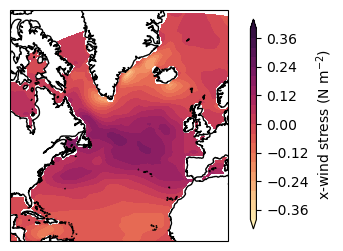

In [16]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), subplot_kw = {'projection': projection})

p1 = axes.contourf(geolon_c, geolat_c, tauu_NA[0], levels = np.linspace(-0.4, 0.4, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')

In [17]:
# Compute anomalies
tauu_mean = tauu_NA.mean('time')
tauu_amly = tauu_NA - tauu_mean

In [18]:
# Compute EOF
coslat_tauu = np.cos(np.deg2rad(tauu_NA.yu_ocean.values))
wgts_tauu = np.sqrt(coslat_tauu)[..., np.newaxis]
solver_DJF_tauu = Eof(tauu_amly, weights = wgts_tauu)
eof_DJF_tauu = solver_DJF_tauu.eofsAsCovariance(neofs = neofs)

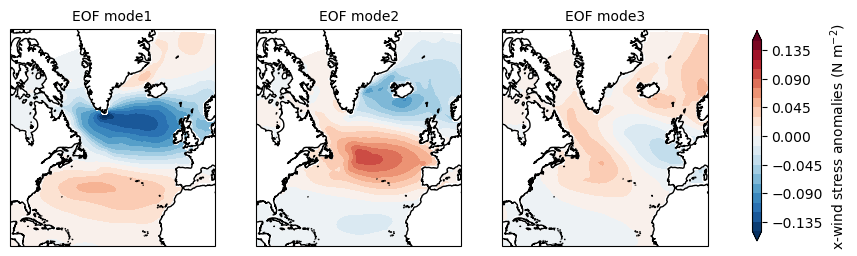

In [19]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(geolon_c, geolat_c, eof_DJF_tauu[0], levels = np.linspace(-0.15, 0.15, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(geolon_c, geolat_c, eof_DJF_tauu[1], levels = np.linspace(-0.15, 0.15, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(geolon_c, geolat_c, eof_DJF_tauu[2], levels = np.linspace(-0.15, 0.15, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress anomalies (N m$^{-2}$)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [20]:
print('Percentage of EOF explained by first ' + str(neigs) + ' modes:' + str(100 * np.round(solver_DJF_tauu.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 modes:[44.940002  25.07       6.7400002]


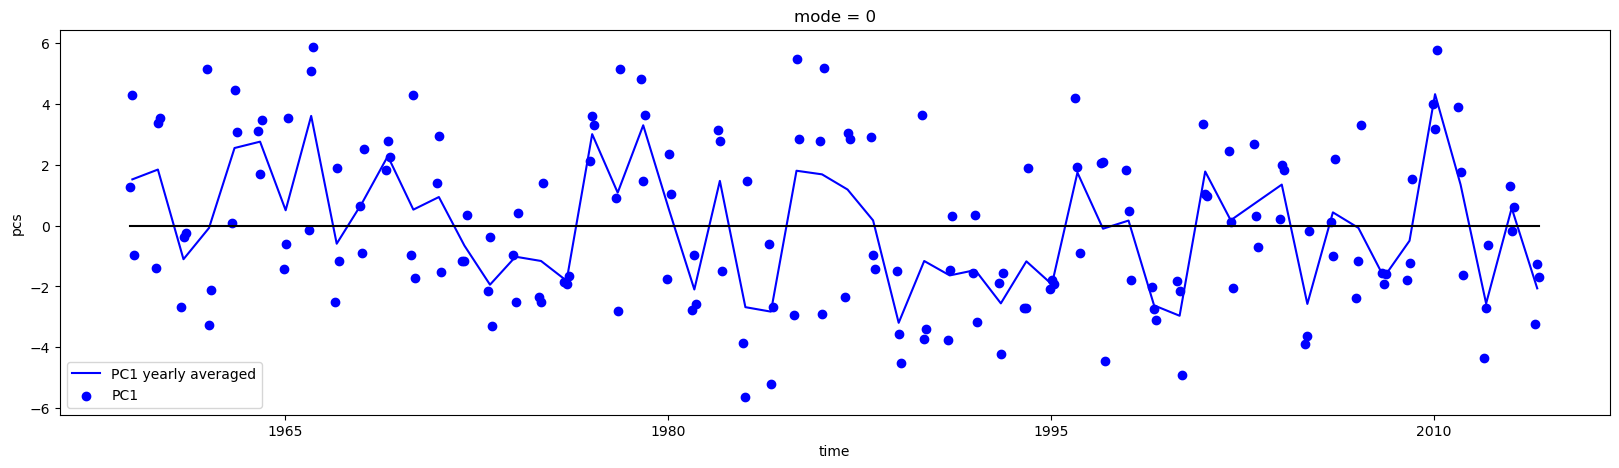

In [22]:
plt.figure(figsize = (20, 5))
#npcs = number of PCs, 
#pscaling = 0 -> unscaled variance scaling of PCs
#         = 1 -> scaled to unit variance
#         = 2 -> PC multiplied by the square root of their eigenvalue

pcs_tauu = solver_DJF_tauu.pcs(npcs = npcs, pcscaling = 0)
pcs_tauu.sel(mode = 0).coarsen(time = 3).mean().plot(color = 'blue', label = 'PC1 yearly averaged')
pcs_tauu.sel(mode = 0).plot.scatter(color = 'blue', label = 'PC1')
##pcs_tauu.sel(mode = 1).coarsen(time = 3).mean().plot(color = 'orange', label = 'PC2', ls = '--')
##pcs_tauu.sel(mode = 2).coarsen(time = 3).mean().plot(color = 'red', label = 'PC3', ls = '--')
plt.plot(pcs_tauu.sel(mode = 1).time, np.zeros(168), color = 'black')
plt.legend()

Correlation is -0.8953417031751986


Text(0.5, 1.0, 'Normalized PC (first mode) of geopotential height and wind stress')

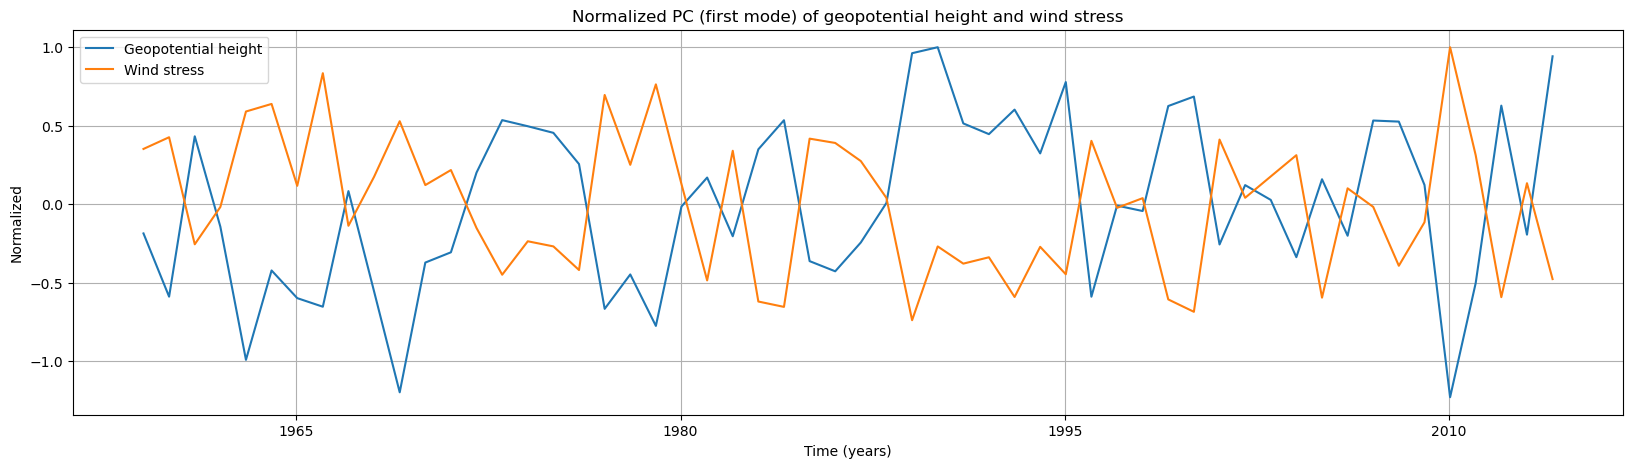

In [23]:
a = pcs_SLP_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_tauu.sel(mode = 0).coarsen(time = 3).mean()
a['time'] = b.time

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Geopotential height')
(b/(np.max(b))).plot(label = 'Wind stress')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of geopotential height and wind stress')

## EOF for curl of wind stress

In [24]:
# Wind stress curl
dtauu_dy_NA = tauu_NA.differentiate('yu_ocean')*(180/np.pi)/r0
dtauu_dy_mean = dtauu_dy_NA.mean('time')
dtauu_dy_amly = dtauu_dy_NA - dtauu_dy_mean

In [25]:
coslat_dtauu_dy = np.cos(np.deg2rad(dtauu_dy_NA.yu_ocean.values))
wgts_dtauu_dy = np.sqrt(coslat_dtauu_dy)[..., np.newaxis]
solver_DJF_dtauu_dy = Eof(dtauu_dy_amly, weights = wgts_dtauu_dy)
eof_DJF_dtauu_dy = solver_DJF_dtauu_dy.eofsAsCovariance(neofs = neofs)

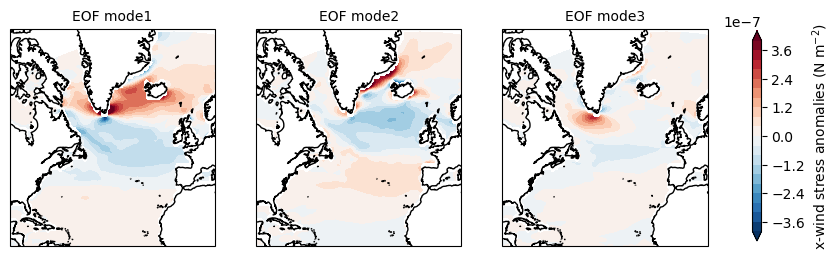

In [26]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(geolon_c, geolat_c, eof_DJF_dtauu_dy[0], levels = np.linspace(-4e-7, 4e-7, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(geolon_c, geolat_c, eof_DJF_dtauu_dy[1], levels = np.linspace(-4e-7, 4e-7, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(geolon_c, geolat_c, eof_DJF_dtauu_dy[2], levels = np.linspace(-4e-7, 4e-7, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress anomalies (N m$^{-2}$)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [27]:
## The eigenvalues are the variance explained by each EOF 
print('Percentage of EOF explained by first ' + str(neigs) + ' modes:' + str(100 * np.round(solver_DJF_dtauu_dy.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 modes:[25.369999 16.1       4.81    ]


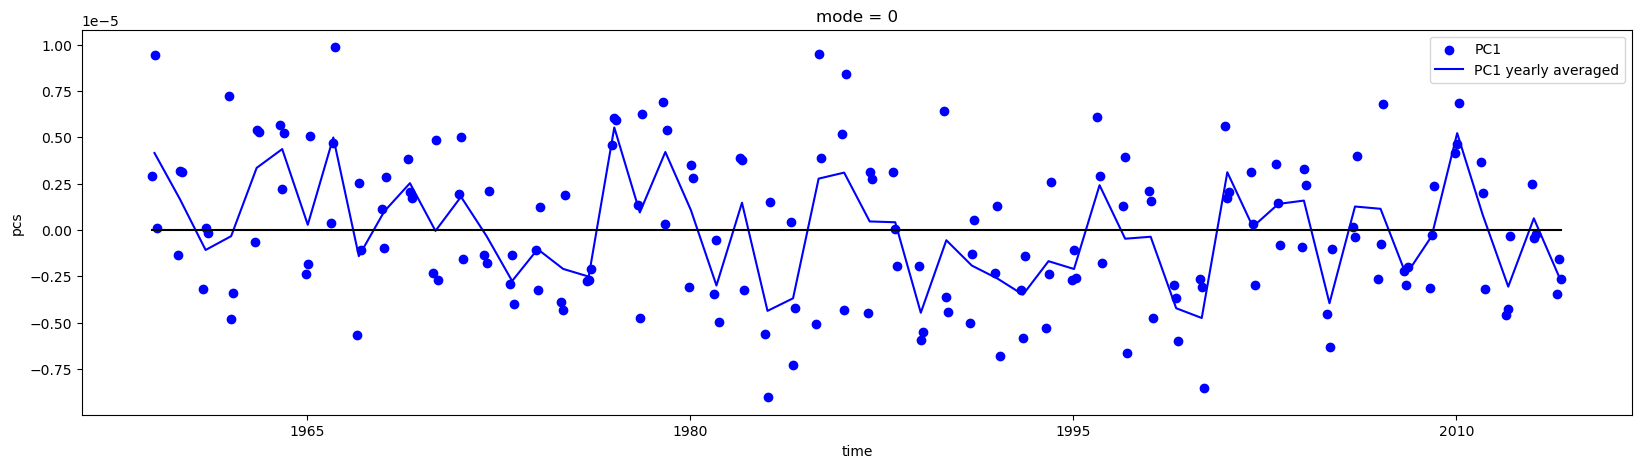

In [28]:
plt.figure(figsize = (20, 5))
#npcs = number of PCs, 
#pscaling = 0 -> unscaled variance scaling of PCs
#         = 1 -> scaled to unit variance
#         = 2 -> PC multiplied by the square root of their eigenvalue

pcs_dtauu_dy = solver_DJF_dtauu_dy.pcs(npcs = npcs, pcscaling = 0)
pcs_dtauu_dy.sel(mode = 0).plot.scatter(color = 'blue', label = 'PC1')
pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean().plot(color = 'blue', label = 'PC1 yearly averaged')
#pcs_dtauu_dy.sel(mode = 1).coarsen(time = 3).mean().plot(color = 'orange', label = 'PC2', ls = '--')
#pcs_dtauu_dy.sel(mode = 2).coarsen(time = 3).mean().plot(color = 'red', label = 'PC3', ls = '--')
plt.plot(pcs_dtauu_dy.sel(mode = 1).time, np.zeros(168), color = 'black')
plt.legend()

### Correlation between first modes of geopotential height and wind stress curl

Correlation is -0.8173240237436142


Text(0.5, 1.0, 'Normalized PC (first mode) of geopotential height and wind stress curl')

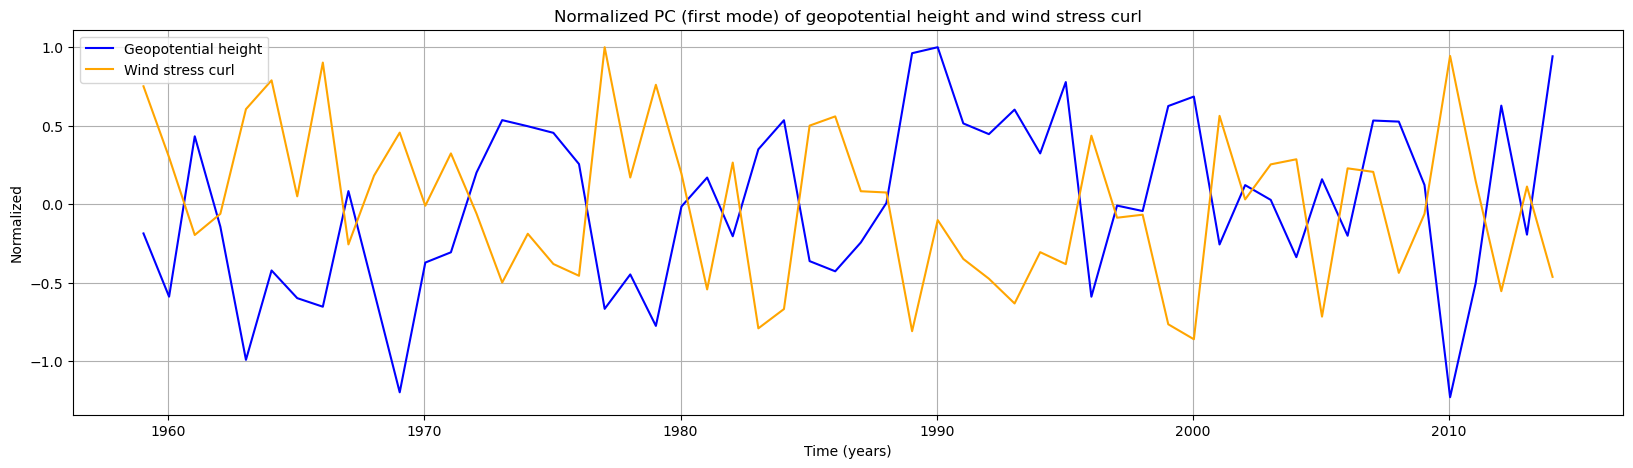

In [29]:
a = pcs_SLP_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean()
b['time'] = a.time

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Geopotential height', color = 'blue')
(b/(np.max(b))).plot(label = 'Wind stress curl', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of geopotential height and wind stress curl')

## NA gyre strength

In [30]:
tx_trans_int_z = cc.querying.getvar(experiment,'tx_trans_int_z', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

tx_trans_int_z = tx_trans_int_z.where(tx_trans_int_z.time.dt.month.isin([12, 1, 2]), drop = True)
mask = tx_trans_int_z/tx_trans_int_z

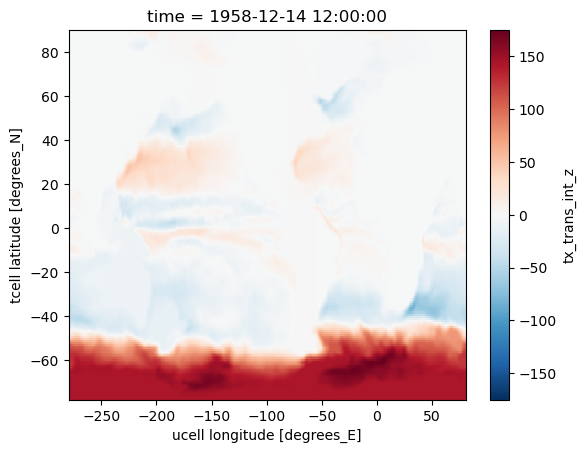

In [31]:
# Calculate barotropic streamfunction
Ψ = -tx_trans_int_z.cumsum('yt_ocean')/(m3_to_Sv * ρ0)
Ψ_ACC = np.nanmin(Ψ.mean('time').sel(xu_ocean = slice(-69, -67), yt_ocean = slice(-80, -55)))
Ψ_g = Ψ - Ψ_ACC
Ψ_g[0].plot()

In [32]:
# Compute anomalies
Ψ_g_DJF = Ψ_g.sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)) * mask
Ψ_g_DJF_mean = Ψ_g_DJF.mean('time')
Ψ_g_DJF_amly = Ψ_g_DJF - Ψ_g_DJF_mean

In [33]:
# Compute EOF for barotropic streamfunction
coslat_Ψ_g = np.cos(np.deg2rad(Ψ_g_DJF.yt_ocean.values))
wgts_Ψ_g = np.sqrt(coslat_Ψ_g)[..., np.newaxis]
solver_DJF_Ψ_g = Eof(Ψ_g_DJF_amly, weights = wgts_Ψ_g)
eof_DJF_Ψ_g = solver_DJF_Ψ_g.eofsAsCovariance(neofs = neofs)

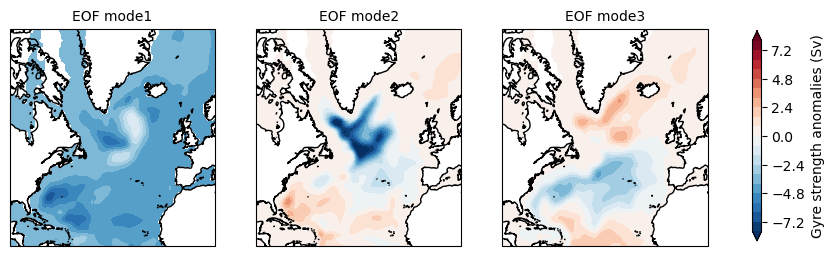

In [34]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, eof_DJF_Ψ_g[0], levels = np.linspace(-8, 8, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, eof_DJF_Ψ_g[1], levels = np.linspace(-8, 8, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, eof_DJF_Ψ_g[2], levels = np.linspace(-8, 8, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Gyre strength anomalies (Sv)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [35]:
## The eigenvalues are the variance explained by each EOF 
print('Percentage of EOF explained by first ' + str(neigs) + ' modes:' + str(100 * np.round(solver_DJF_Ψ_g.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 modes:[67.799995 10.7       5.82    ]


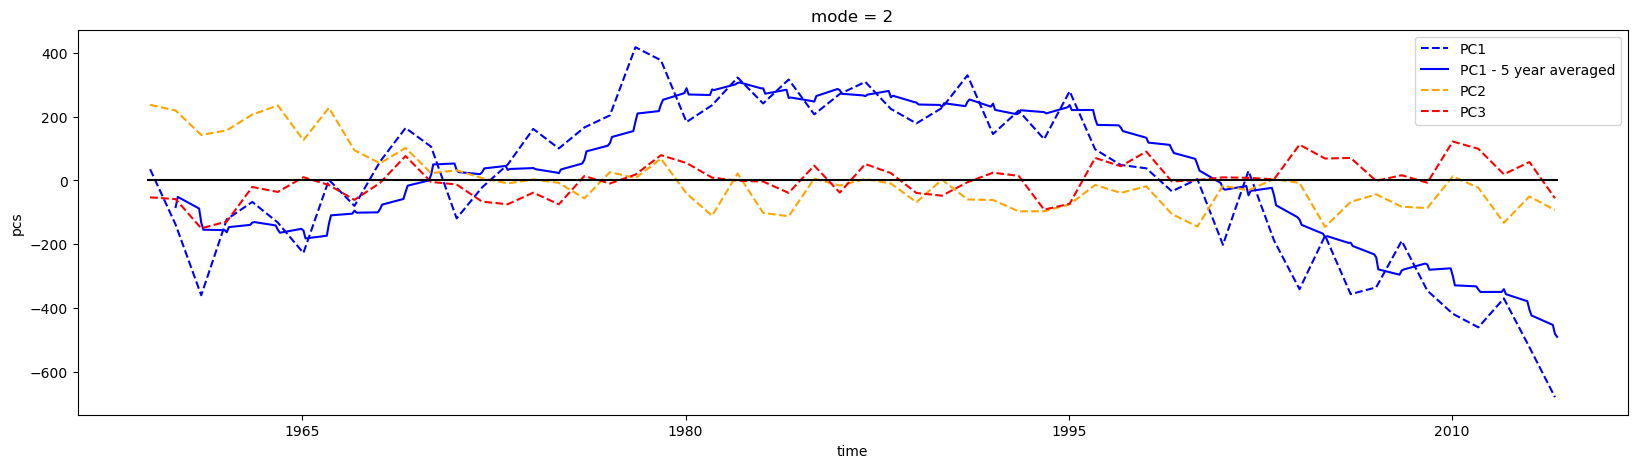

In [36]:
plt.figure(figsize = (20, 5))
#npcs = number of PCs, 
#pscaling = 0 -> unscaled variance scaling of PCs
#         = 1 -> scaled to unit variance
#         = 2 -> PC multiplied by the square root of their eigenvalue

pcs_Ψ_g = solver_DJF_Ψ_g.pcs(npcs = npcs, pcscaling = 0)
pcs_Ψ_g.sel(mode = 0).coarsen(time = 3).mean().plot(color = 'blue', label = 'PC1', ls = '--')
pcs_Ψ_g.sel(mode = 0).rolling(time = 15, min_periods = 5).mean().plot(color = 'blue', label = 'PC1 - 5 year averaged')
pcs_Ψ_g.sel(mode = 1).coarsen(time = 3).mean().plot(color = 'orange', label = 'PC2', ls = '--')
pcs_Ψ_g.sel(mode = 2).coarsen(time = 3).mean().plot(color = 'red', label = 'PC3', ls = '--')
plt.plot(pcs_Ψ_g.sel(mode = 1).time, np.zeros(168), color = 'black')
plt.legend()

### Correlation between first mode of wind stress curl and second mode of gyre strength

Correlation is 0.6635661793984543


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress curl and gyre strength')

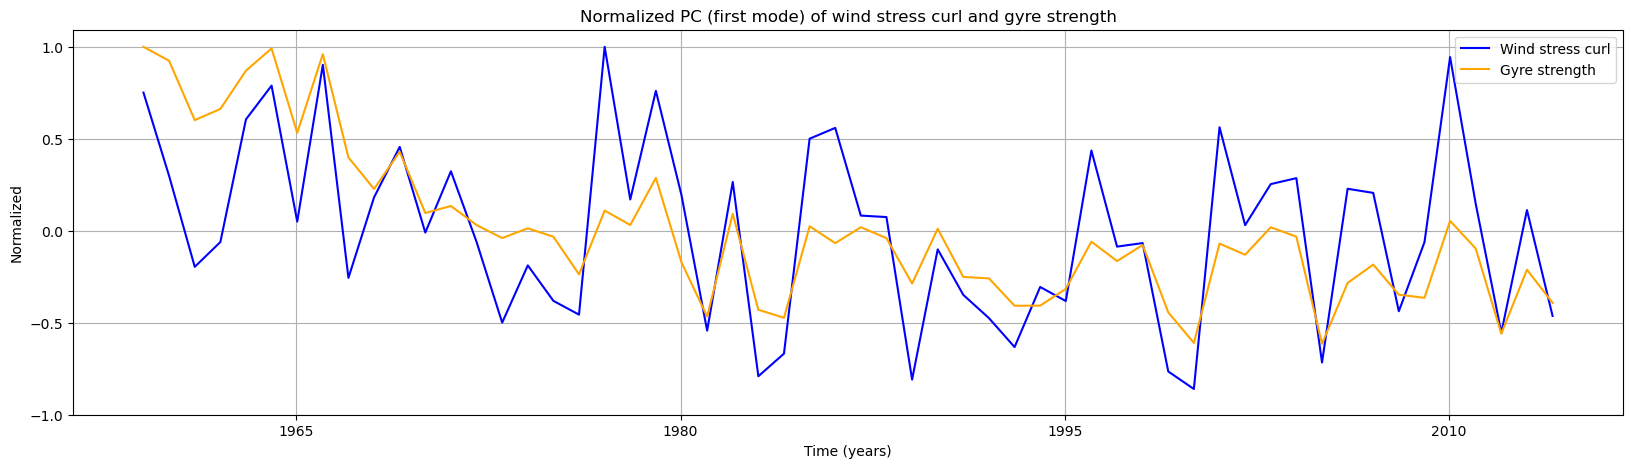

In [37]:
a = pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_Ψ_g.sel(mode = 1).coarsen(time = 3).mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress curl', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress curl and gyre strength')

### Correlation between first mode of wind stress and second mode of gyre strength

Correlation is 0.6652319680198124


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress and gyre strength')

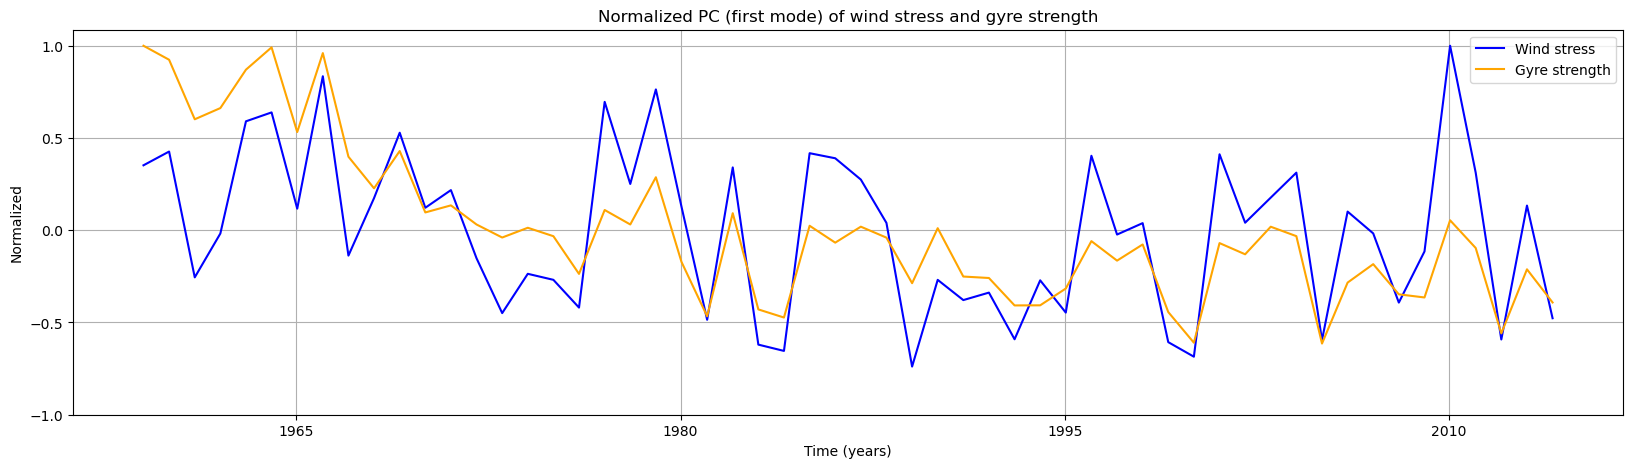

In [38]:
a = pcs_tauu.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_Ψ_g.sel(mode = 1).coarsen(time = 3).mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress and gyre strength')

### Correlation between first mode of air pressure at sea level and second mode of gyre strength

Correlation is -0.5857703933550009


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress curl and gyre strength')

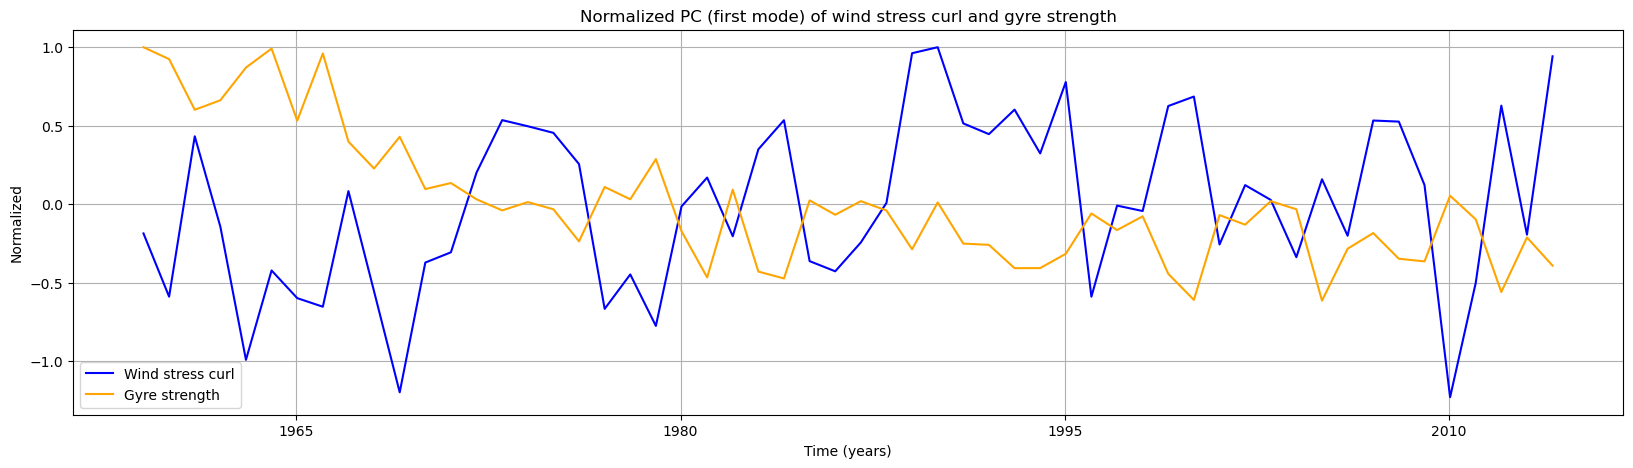

In [39]:
a = pcs_SLP_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_Ψ_g.sel(mode = 1).coarsen(time = 3).mean()
a['time'] = b.time

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress curl', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress curl and gyre strength')

## Towards more physically sound correlations

In [170]:
area_t = cc.querying.getvar(experiment, 'area_t', session, frequency = 'static', n = 1)
area_u = cc.querying.getvar(experiment, 'area_u', session, frequency = 'static', n = 1)

In [171]:
area_t = area_t.rename('area-t')
area_u = area_u.rename('area-u')

paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
data = xr.merge((area_t, area_u))
data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['xt_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
data.coords['yu_ocean'].attrs.update(axis='Y')
data.coords['yt_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)

grid_itp = xgcm.Grid(data, periodic=['X'])
area_t_itp = grid_itp.interp(area_t, 'X')
area_u_itp = grid_itp.interp(area_t, 'Y')

In [91]:
area_t_itp = area_t_itp * (tx_trans_int_z.mean('time')/tx_trans_int_z.mean('time'))

In [92]:
area_t_NA = area_t_itp.sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
#area_u_NA = area_u_itp.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

In [97]:
area_t_normalize = preprocessing.normalize(area_t_NA.fillna(0))
area_t_normalize = area_t_normalize * (area_t_NA/area_t_NA)
Ψ_g_mag = Ψ_g_DJF.weighted(area_t_normalize.fillna(0)).quantile(0.95, dim = {"yt_ocean", "xu_ocean"})/(m3_to_Sv * ρ0)

### Correlation between first mode of wind stress curl and gyre strength

Correlation is 0.12126547198629457


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress curl and gyre strength')

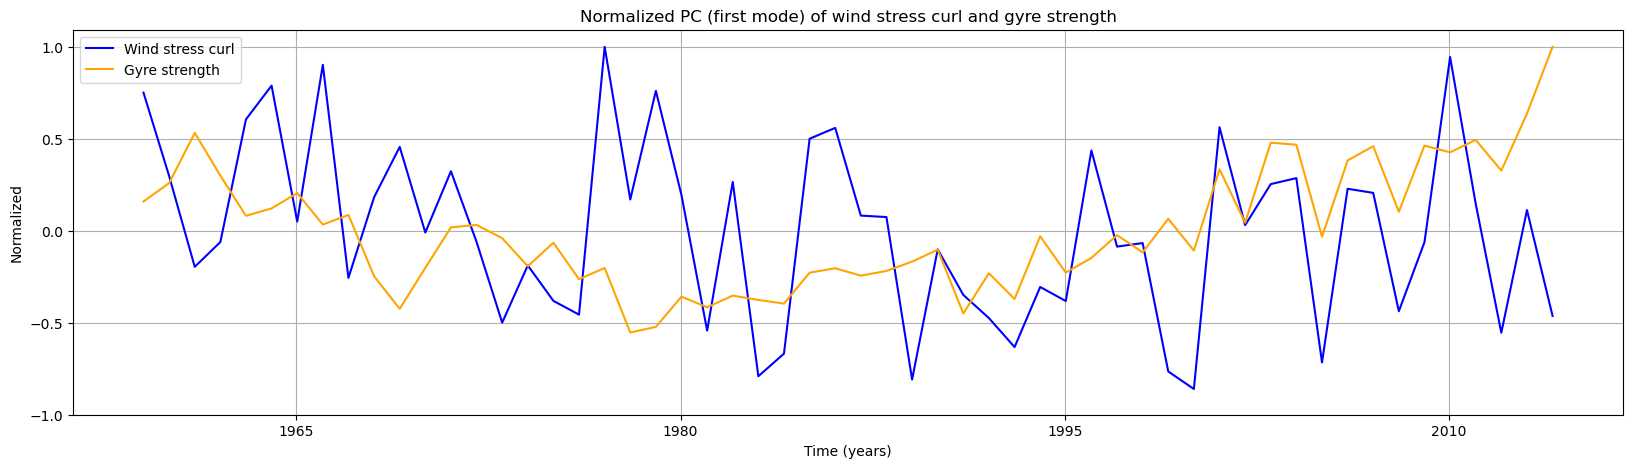

In [101]:
a = pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean()
b = Ψ_g_mag.coarsen(time = 3).mean()
b = b - b.mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress curl', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress curl and gyre strength')

### Correlation between first mode of wind stress and gyre strength

Correlation is 0.08884027560313273


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress and gyre strength')

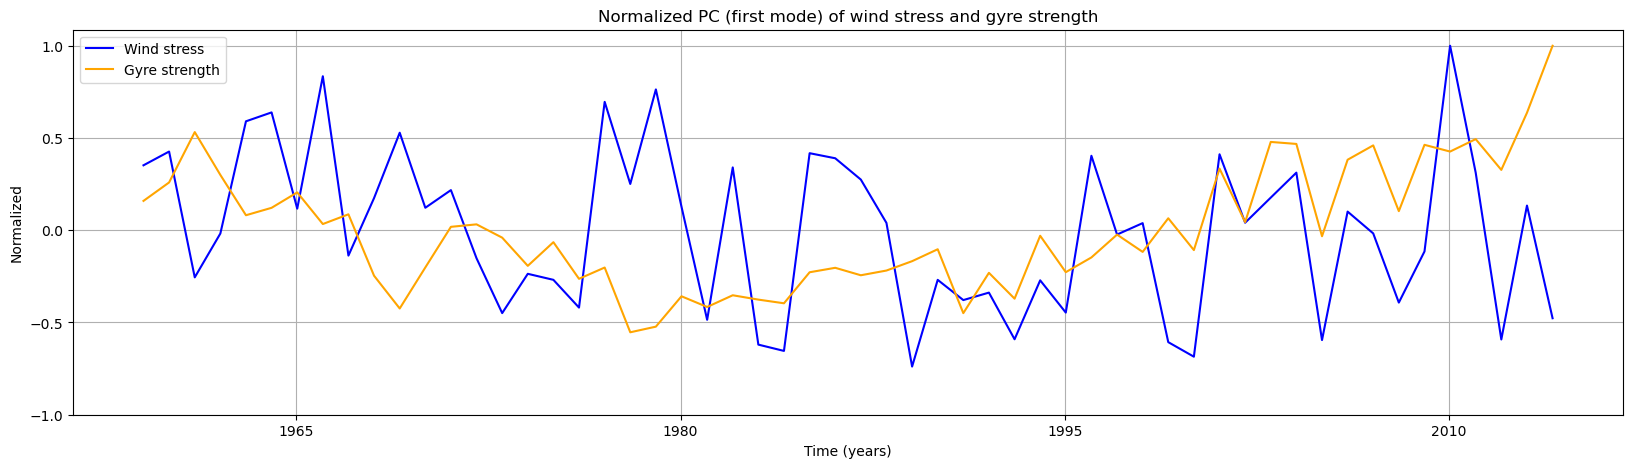

In [102]:
a = pcs_tauu.sel(mode = 0).coarsen(time = 3).mean()
b = Ψ_g_mag.coarsen(time = 3).mean()
b = b - b.mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress and gyre strength')

### Correlation between first mode of air pressure at sea level and gyre strength

Correlation is 0.02742056860041044


Text(0.5, 1.0, 'Normalized PC (first mode) of geopotential height and gyre strength')

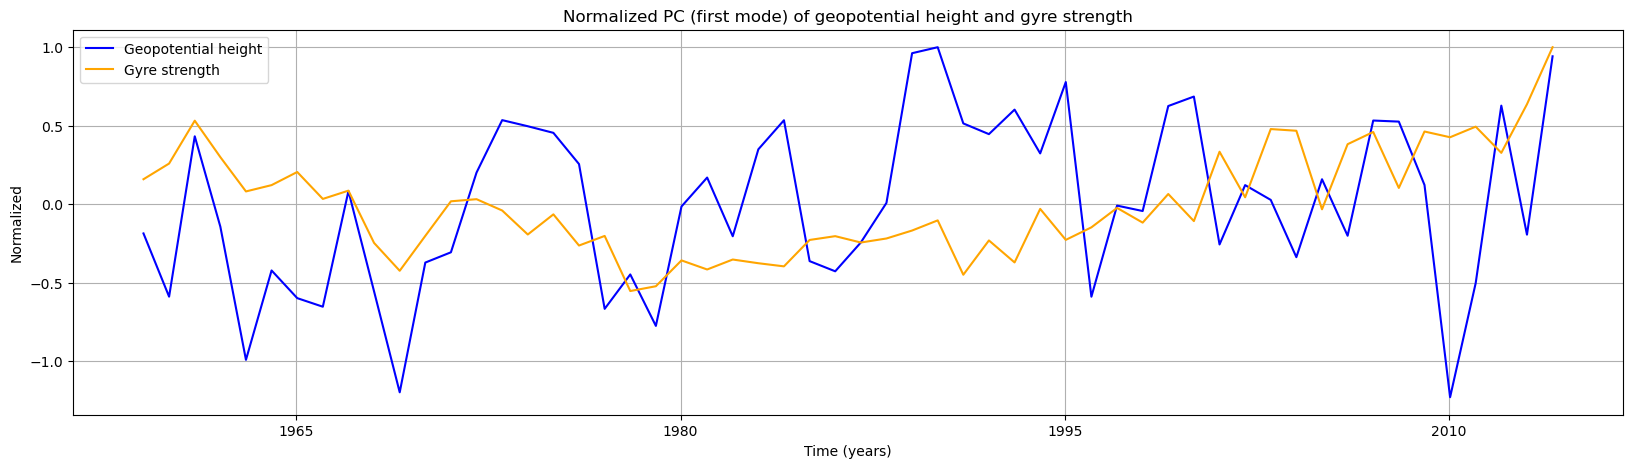

In [105]:
a = pcs_SLP_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = Ψ_g_mag.coarsen(time = 3).mean()
b = b - b.mean()
a['time'] = b.time

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Geopotential height', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of geopotential height and gyre strength')

## Alternative gyre strength computation: Consider only the top 1100m of the ocean

In [172]:
ty_trans = cc.querying.getvar(experiment,'ty_trans', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

ty_trans = ty_trans.sel(time = slice(start_time, end_time)).where(ty_trans.time.dt.month.isin([12, 1, 2]), drop = True)
mask = ty_trans[0][0]/ty_trans[0][0]

ty_trans_int_z = ty_trans.sel(st_ocean = slice(0, 1100)).sum('st_ocean')

In [173]:
ty_trans_int_z_NA = ty_trans_int_z.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
Ψ_NA = ty_trans_int_z_NA.cumsum('xt_ocean') * mask

In [177]:
area_u_itp = grid_itp.interp(area_t, 'Y')
area_u_itp = area_u_itp * (ty_trans_int_z.mean('time')/ty_trans_int_z.mean('time'))
area_u_NA = area_u_itp.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

In [178]:
area_u_normalize = preprocessing.normalize(area_u_NA.fillna(0))
area_u_normalize = area_u_normalize * (area_u_NA/area_u_NA)
Ψ_mag = Ψ_NA.weighted(area_u_normalize.fillna(0)).quantile(0.95, dim = {"yu_ocean", "xt_ocean"})/(m3_to_Sv * ρ0)

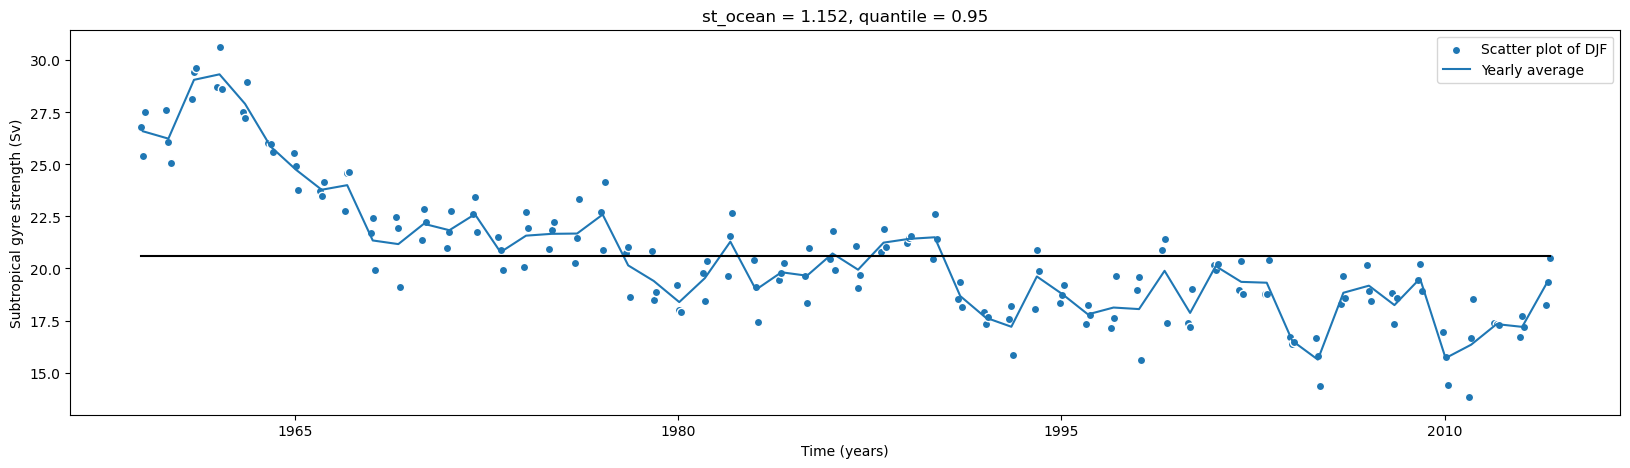

In [179]:
plt.figure(figsize = (20, 5))
Ψ_mag.plot.scatter(label = 'Scatter plot of DJF')
Ψ_mag.coarsen(time = 3).mean().plot(label = 'Yearly average')
plt.plot(Ψ_mag.time, Ψ_mag.mean('time').values * np.ones(168), color = 'black')
plt.ylabel('Subtropical gyre strength (Sv)')
plt.xlabel('Time (years)')
plt.legend()

### Correlation between first mode of wind stress curl and alternative gyre strength

Correlation is 0.26505160646297893


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress curl and gyre strength')

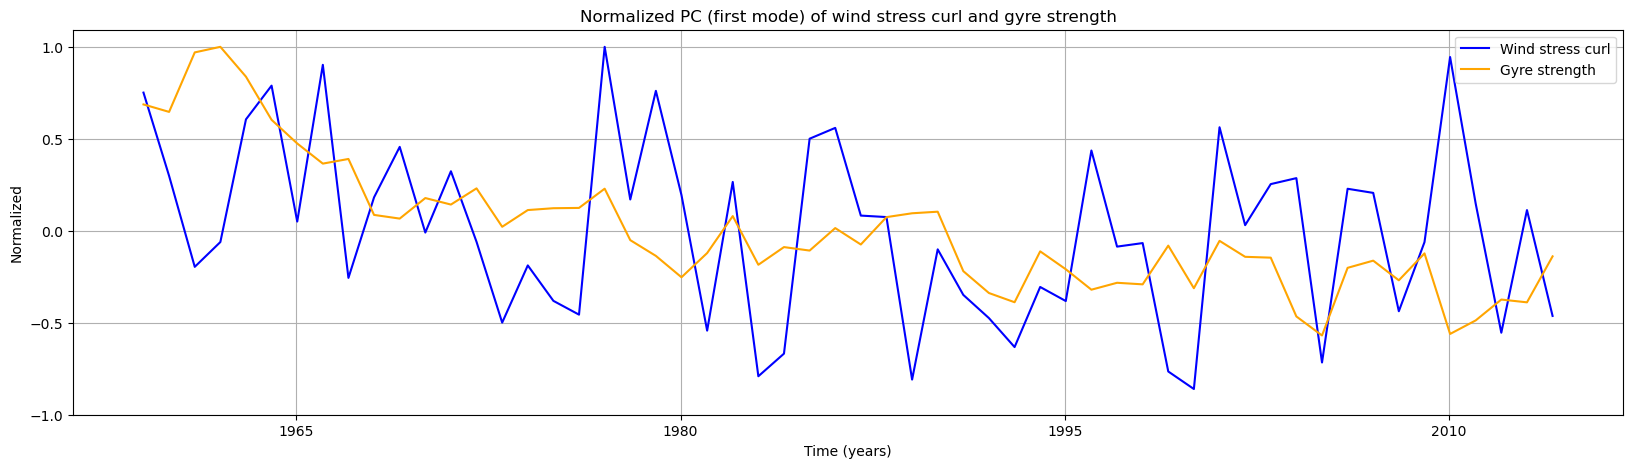

In [181]:
a = pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean()
b = Ψ_mag.coarsen(time = 3).mean()
b = b - b.mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress curl', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress curl and gyre strength')

### Correlation between first mode of wind stress and alternative gyre strength

Correlation is 0.22418524744073004


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress and gyre strength')

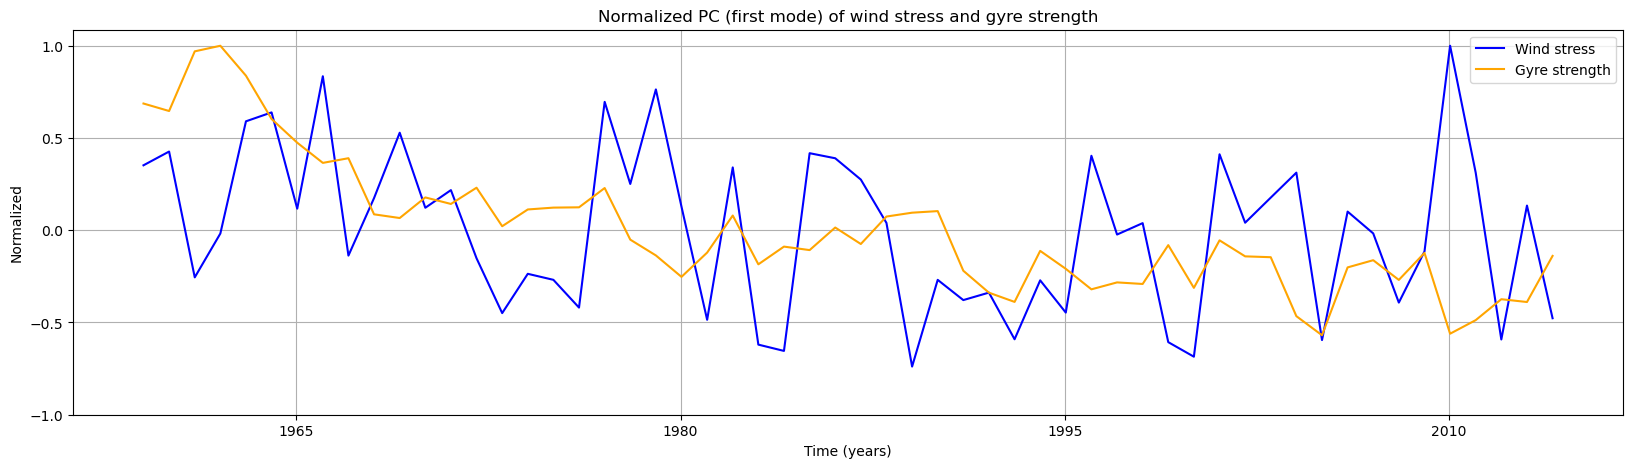

In [182]:
a = pcs_tauu.sel(mode = 0).coarsen(time = 3).mean()
b = Ψ_mag.coarsen(time = 3).mean()
b = b - b.mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress and gyre strength')

### Correalation between first mode of air pressure at sea level and gyre strength

Correlation is -0.1886749788026367


Text(0.5, 1.0, 'Normalized PC (first mode) of geopotential height and gyre strength')

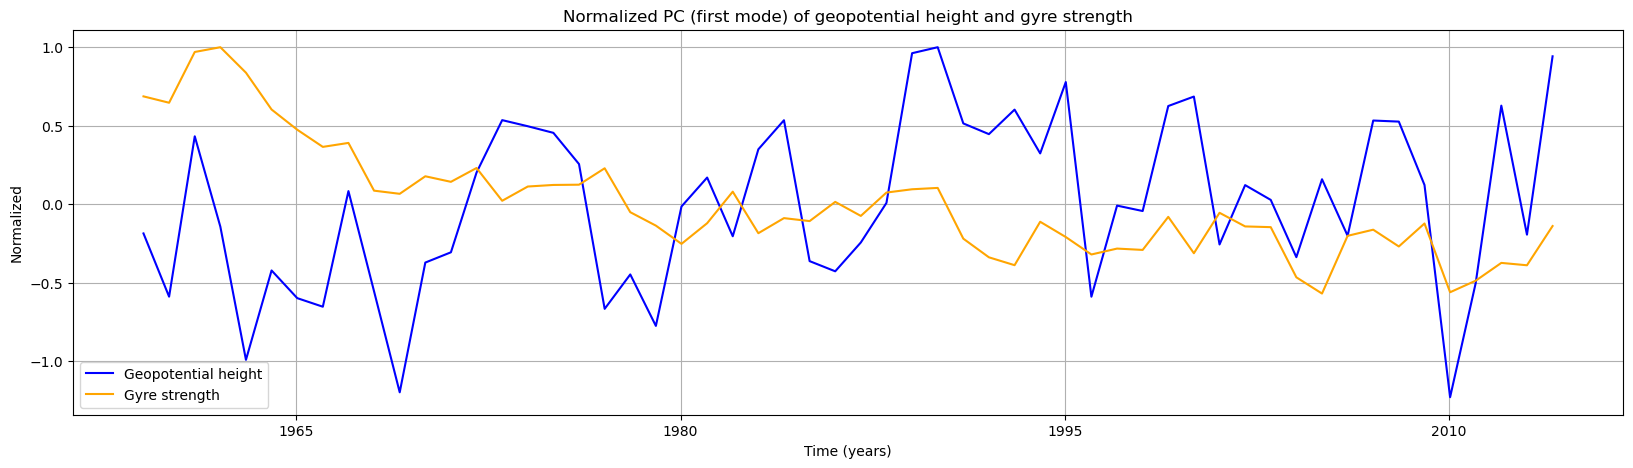

In [184]:
a = pcs_SLP_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = Ψ_mag.coarsen(time = 3).mean()
b = b - b.mean()
a['time'] = b.time

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Geopotential height', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of geopotential height and gyre strength')

In [185]:
# Function that linearly regresses for a given time series
def dpsi_pred_func(a, m, c):
    dpsi_pred = m*a+c
    return dpsi_pred

# List of coordinates to check
x_val = [-60, -60, -30, -60, -40, -40]
y_val = [25, 30, 20, 40, 40, 30]

In [186]:
a = pcs_SLP_DJF.sel(mode = 0)
b = Ψ_g_DJF

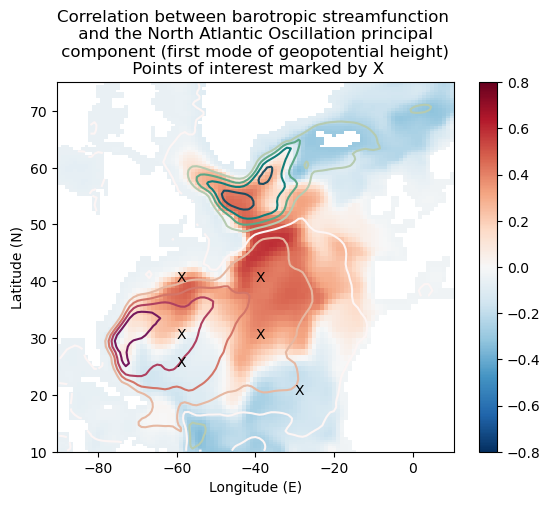

In [201]:
a = pcs_SLP_DJF.sel(mode = 0)
b = Ψ_g_DJF
a['time'] = b.time

xr.corr(a, b, 'time').plot(vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r')

Ψ_g_DJF.mean('time').plot.contour(levels = np.linspace(-30, 30, 11), cmap = cm.cm.curl)
plt.xlabel('Longitude (E)')
plt.ylabel('Latitude (N)')
for i in range(len(x_val)):
    plt.text(x = x_val[i], y = y_val[i], s = 'X', color = 'black')
plt.title('Correlation between barotropic streamfunction \n and the North Atlantic Oscillation principal \n component' + 
          ' (first mode of geopotential height) \n Points of interest marked by X');

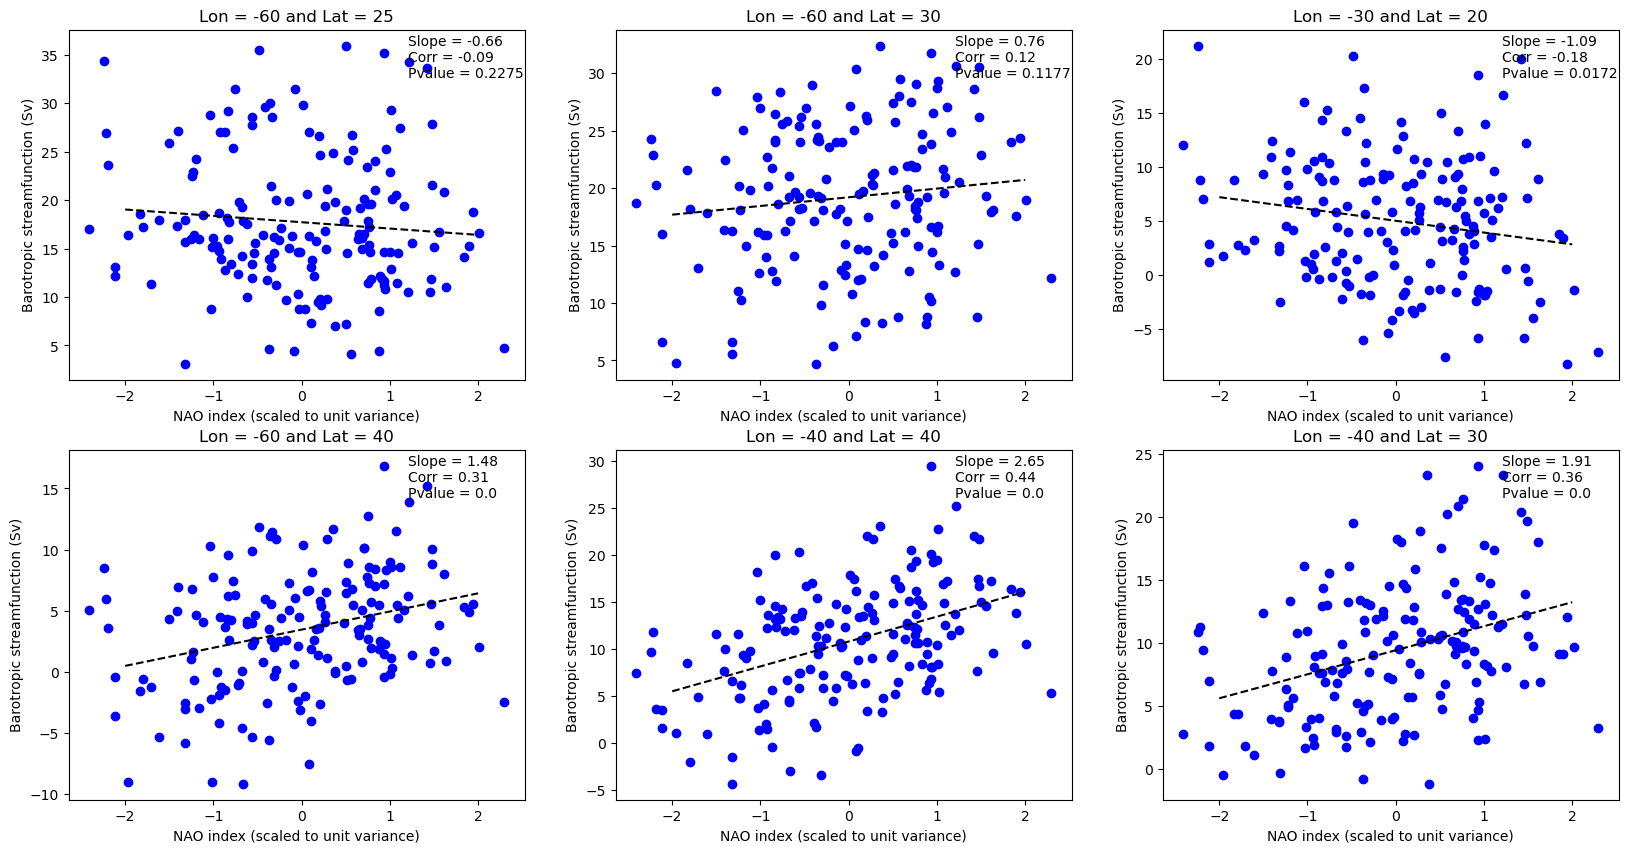

In [206]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
for i in range(len(x_val)):

    a = solver_DJF_SLP.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_g_DJF.sel(xu_ocean = x_val[i], method = 'nearest').sel(yt_ocean = y_val[i], method = 'nearest').values
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/3)][int(i%3)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/3)][int(i%3)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/3)][int(i%3)].set_ylabel('Barotropic streamfunction (Sv)')
    axes[int(i/3)][int(i%3)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/3)][int(i%3)].text(1.2, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/3)][int(i%3)].text(1.2, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/3)][int(i%3)].text(1.2, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/3)][int(i%3)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))

### Is there a time-lagged correlation?

In [209]:
Ψ_g_DJF_1mtlag = xr.DataArray(Ψ_g_DJF[1:], coords = [Ψ_g_DJF.time[0:-1], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xu_ocean],  
                              dims = ['time', 'yt_ocean', 'xu_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_g_DJF_1yrlag = xr.DataArray(Ψ_g_DJF[3:], coords = [Ψ_g_DJF.time[0:-3], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xu_ocean],  
                              dims = ['time', 'yt_ocean', 'xu_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_g_DJF_2yrlag = xr.DataArray(Ψ_g_DJF[6:], coords = [Ψ_g_DJF.time[0:-6], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xu_ocean],  
                              dims = ['time', 'yt_ocean', 'xu_ocean'], name = 'Psi', attrs = {'units':'Sv'})

Text(0.5, 1.0, '2 year lag')

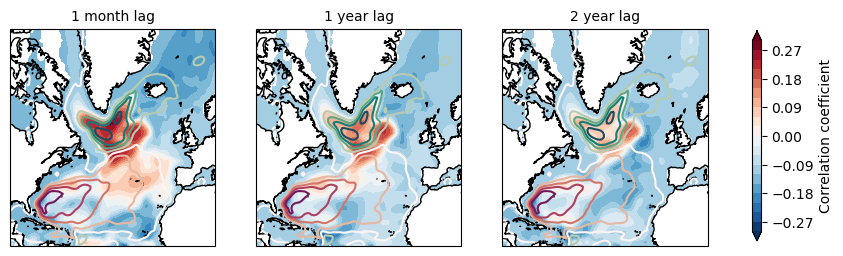

In [214]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

clev = np.linspace(-0.3, 0.3, 21)

a = pcs_SLP_DJF.sel(mode = 0)
a['time'] = Ψ_g_DJF.time

p1 = axes[0].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, xr.corr(a, Ψ_g_DJF_1mtlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, xr.corr(a, Ψ_g_DJF_1yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p3 = axes[2].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, xr.corr(a, Ψ_g_DJF_2yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')

for i in range(3):
    axes[i].contour(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, Ψ_g_DJF.mean('time'), cmap = cm.cm.curl, levels = np.linspace(-30, 30, 11), transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Correlation coefficient', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    
axes[0].set_title('1 month lag', fontsize = 10)
axes[1].set_title('1 year lag', fontsize = 10)
axes[2].set_title('2 year lag', fontsize = 10)

## 0-1100 m depth gyre strength case

Text(0.5, 1.0, 'Correlation between 0-1100m streamfunction \n and the North Atlantic Oscillation principal \n component (first mode of geopotential height)')

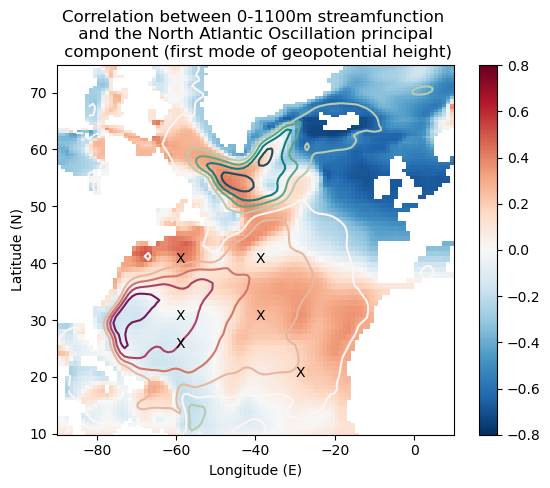

In [215]:
a = pcs_SLP_DJF.sel(mode = 0)
b = Ψ_NA
a['time'] = b.time

xr.corr(a, b, 'time').plot(vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r')

Ψ_g_DJF.mean('time').plot.contour(levels = np.linspace(-30, 30, 11), cmap = cm.cm.curl)
plt.xlabel('Longitude (E)')
plt.ylabel('Latitude (N)')
for i in range(len(x_val)):
    plt.text(x = x_val[i], y = y_val[i], s = 'X', color = 'black')
plt.title('Correlation between 0-1100m streamfunction \n and the North Atlantic Oscillation principal \n component (first mode of geopotential height)')

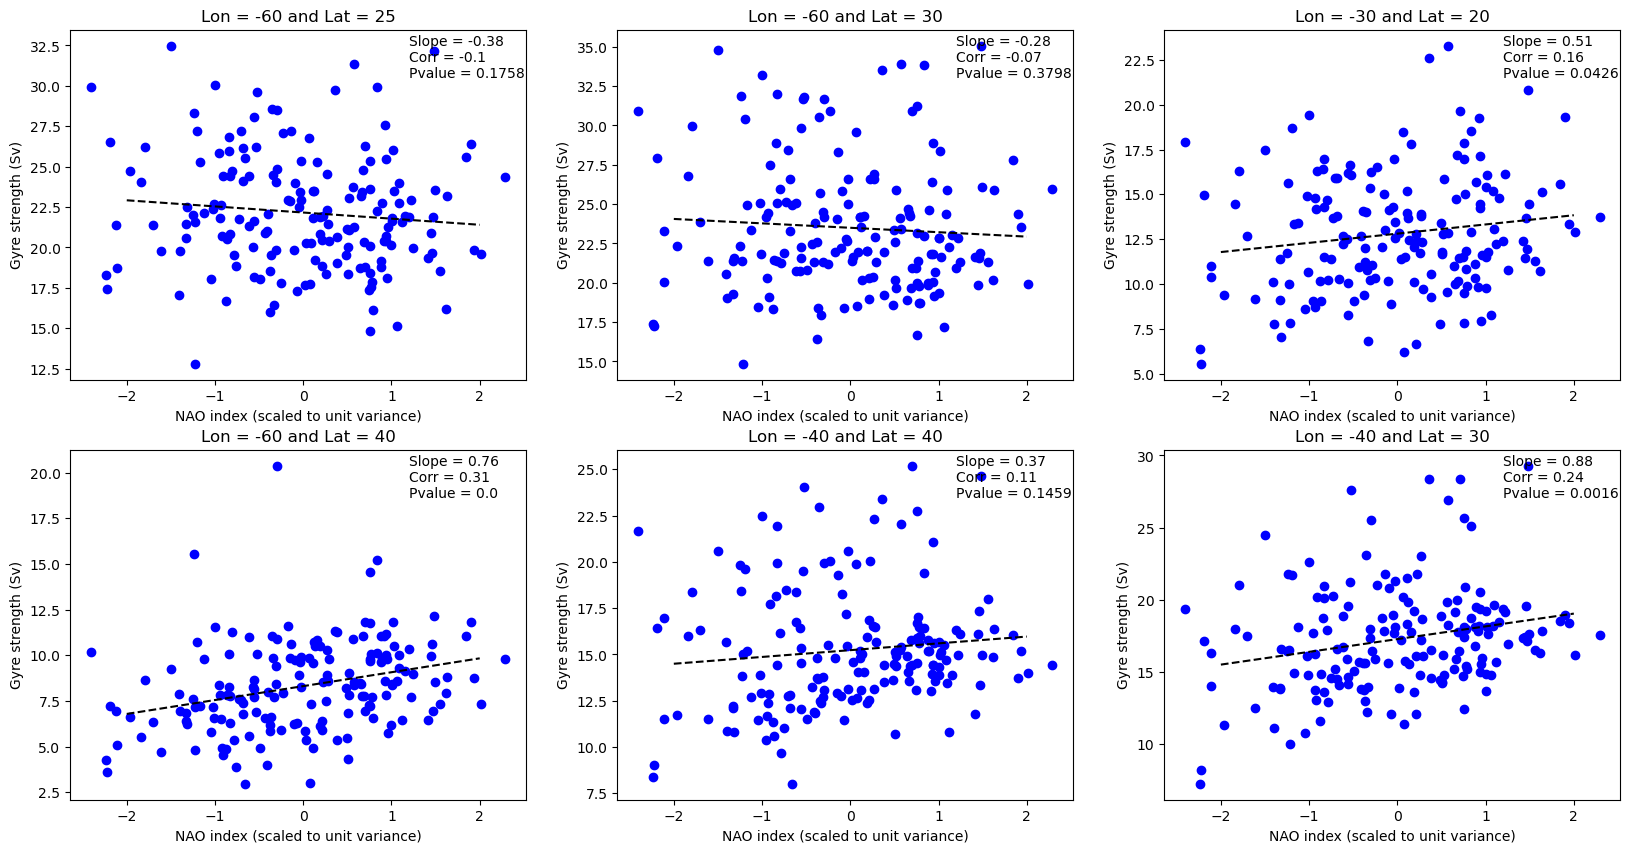

In [219]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
for i in range(len(x_val)):

    a = solver_DJF_SLP.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_NA.sel(xt_ocean = x_val[i], method = 'nearest').sel(yu_ocean = y_val[i], method = 'nearest').values / (ρ0 * m3_to_Sv)
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/3)][int(i%3)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/3)][int(i%3)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/3)][int(i%3)].set_ylabel('Gyre strength (Sv)')
    axes[int(i/3)][int(i%3)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/3)][int(i%3)].text(1.2, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/3)][int(i%3)].text(1.2, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/3)][int(i%3)].text(1.2, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/3)][int(i%3)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))

### Is there a time-lagged correlation

In [220]:
Ψ_NA_1mtlag = xr.DataArray(Ψ_NA[1:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-1], Ψ_NA.yu_ocean, Ψ_NA.xt_ocean],  
                           dims = ['time', 'yu_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_NA_1yrlag = xr.DataArray(Ψ_NA[3:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-3], Ψ_NA.yu_ocean, Ψ_NA.xt_ocean],  
                           dims = ['time', 'yu_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_NA_2yrlag = xr.DataArray(Ψ_NA[6:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-6], Ψ_NA.yu_ocean, Ψ_NA.xt_ocean],  
                           dims = ['time', 'yu_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})

Text(0.5, 1.0, '2 year lag')

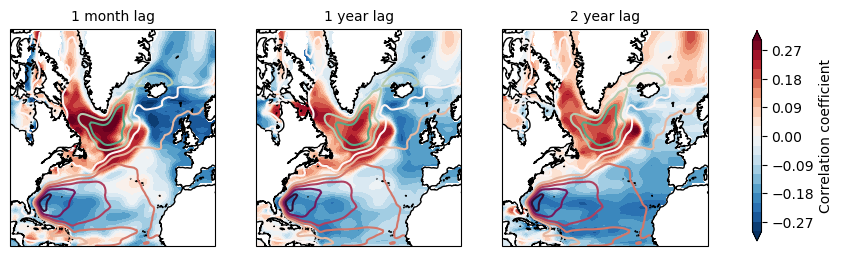

In [224]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

clev = np.linspace(-0.3, 0.3, 21)

a = pcs_SLP_DJF.sel(mode = 0)
a['time'] = Ψ_NA.time

p1 = axes[0].contourf(Ψ_NA.xt_ocean, Ψ_NA.yu_ocean, xr.corr(a, Ψ_NA_1mtlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(Ψ_NA.xt_ocean, Ψ_NA.yu_ocean, xr.corr(a, Ψ_NA_1yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p3 = axes[2].contourf(Ψ_NA.xt_ocean, Ψ_NA.yu_ocean, xr.corr(a, Ψ_NA_2yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')

for i in range(3):
    axes[i].contour(Ψ_NA.xt_ocean, Ψ_NA.yu_ocean, Ψ_NA.mean('time')/(ρ0 * m3_to_Sv), cmap = cm.cm.curl, levels = np.linspace(-30, 30, 11), transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Correlation coefficient', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    
axes[0].set_title('1 month lag', fontsize = 10)
axes[1].set_title('1 year lag', fontsize = 10)
axes[2].set_title('2 year lag', fontsize = 10)